In [1]:
#install library
!pip install nltk textblob wordcloud
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.6 MB/s eta 0:00:00


step 2: import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

STEP 3: load data

In [5]:
# Step 3: Upload and unzip the file
from google.colab import files
import zipfile
import os

# Upload zip file
print("Please upload your ZIP file...")
uploaded = files.upload()

# Get the uploaded filename
zip_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {zip_filename}")

# Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('.')
    print(f"✅ Extracted files: {zip_ref.namelist()}")

# Step 4: Load the CSV
df = pd.read_csv('Reviews.csv',
                 on_bad_lines='skip',  # Skip bad rows
                 engine='python')



Please upload your ZIP file...


Saving amazone product review.zip to amazone product review (1).zip

✅ Uploaded: amazone product review (1).zip
✅ Extracted files: ['Reviews.csv']

✅ Total reviews loaded: 568454
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First few rows:
   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]


In [6]:
print(f"\n✅ Total reviews loaded: {len(df)}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())


✅ Total reviews loaded: 568454
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First few rows:
   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]


STEP 4: take sample (10k review)

In [7]:
df = df.sample(n=10000, random_state=42)
print(f"working with {len(df)} reviews")

working with 10000 reviews


STEP 5 : Basic cleaning

In [8]:
df = df.dropna(subset=['Text','Score'])

In [9]:
# Create sentiment labels from ratings
# 1-2 star = negative
# 3 stars  = neutral
# 4-5 stars= positive

def get_sentiment(score):
  if score <= 2:
    return 'negative'
  elif score == 3:
    return 'neutral'
  else:
    return 'positive'

df['actual_sentiment'] = df['Score'].apply(get_sentiment)

print("\nSentiment Distribution:")
print(df['actual_sentiment'].value_counts())



Sentiment Distribution:
actual_sentiment
positive    7852
negative    1398
neutral      750
Name: count, dtype: int64


STEP 6: sentiment analysis with textblob

In [10]:
print("Analysing with textblob")

def textblob_analysis(text):
  analysis = TextBlob(text)

  #get polarity score (-1 to 1)
  polarity = analysis.sentiment.polarity

  #classify sentiments
  if polarity > 0:
    return 'positive', polarity
  elif polarity < 0:
    return 'negative', polarity
  else:
    return 'neutral', polarity

Analysing with textblob


In [12]:
#Applying textblob
results = df['Text'].apply(textblob_analysis)
df['textblob_sentiment'] = results.apply(lambda x: x[0])
df['polarity'] = results.apply(lambda x: x[1])

STEP 7: sentiment analysis with vader

In [13]:
print("Analysing with vader")

vader = SentimentIntensityAnalyzer()

def vader_analysis(text):
  scores = vader.polarity_scores(text)
  compound = scores['compound']

  #classify sentiment
  if compound >= 0.05:
    return 'positive', compound
  elif compound <= -0.05:
    return 'negative', compound
  else:
    return 'neutral', compound

#Apply vader
results = df['Text'].apply(vader_analysis)
df['vader_sentiment'] = results.apply(lambda x: x[0])
df['compound'] = results.apply(lambda x: x[1])

Analysing with vader


STEP 8: Calculate accuracy

In [18]:
from sklearn.metrics import accuracy_score

textblob_acc = accuracy_score(df['actual_sentiment'], df['textblob_sentiment'])
vader_acc = accuracy_score(df['actual_sentiment'], df['vader_sentiment'])

print(f" RESULTS:")
print(f"TextBlob Accuracy: {textblob_acc:.2%}")
print(f"VADER Accuracy: {vader_acc:.2%}")

 RESULTS:
TextBlob Accuracy: 79.49%
VADER Accuracy: 80.99%


STEP 9: VISUALIZATION

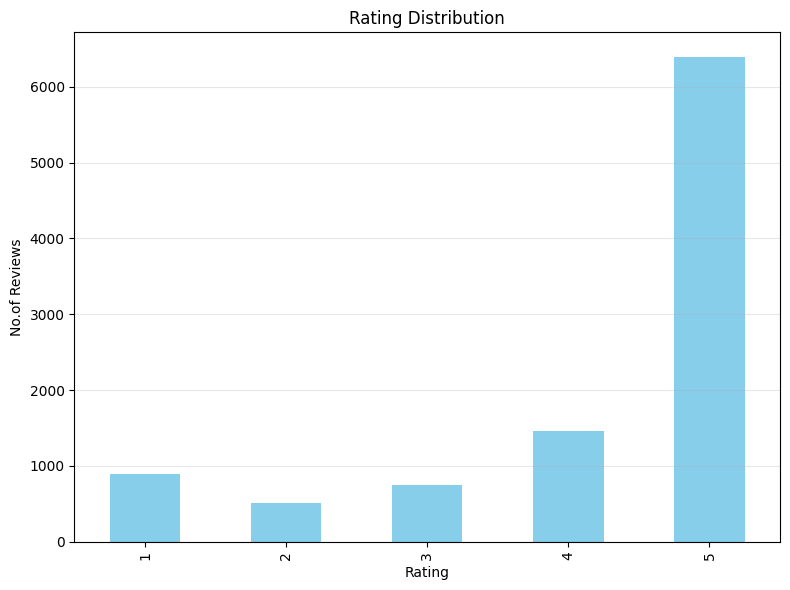

In [20]:
# Figure 1: rating distribution
plt.figure(figsize=(8, 6))
df['Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('No.of Reviews')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

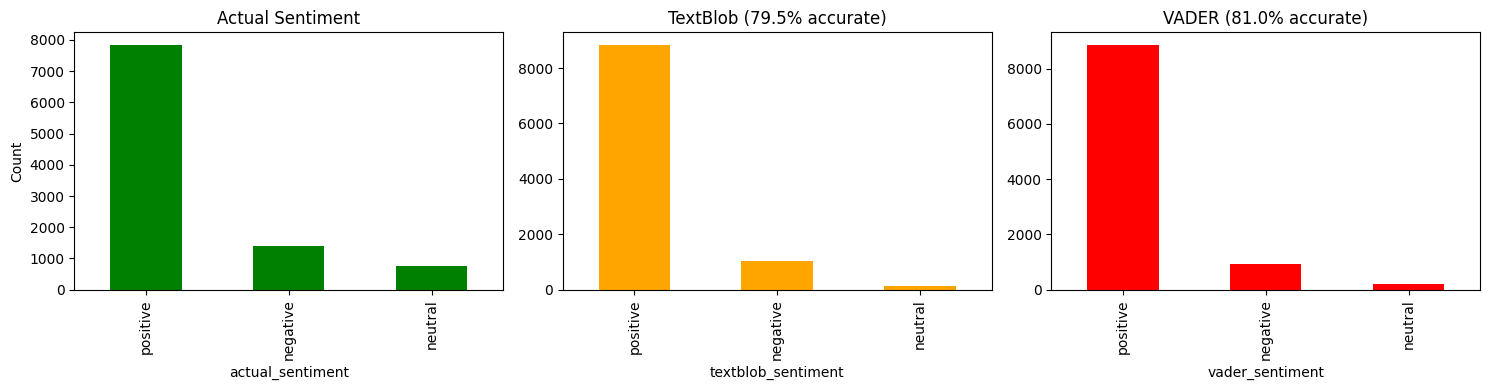

In [21]:
#Figure 2: Comparing actual vs predicted sentiment

fig, axes  = plt.subplots(1, 3, figsize=(15, 4))

df['actual_sentiment'].value_counts().plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title('Actual Sentiment')
axes[0].set_ylabel('Count')

df['textblob_sentiment'].value_counts().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title(f'TextBlob ({textblob_acc:.1%} accurate)')

df['vader_sentiment'].value_counts().plot(kind='bar', ax=axes[2], color='red')
axes[2].set_title(f'VADER ({vader_acc:.1%} accurate)')

plt.tight_layout()
plt.show()
#Actual

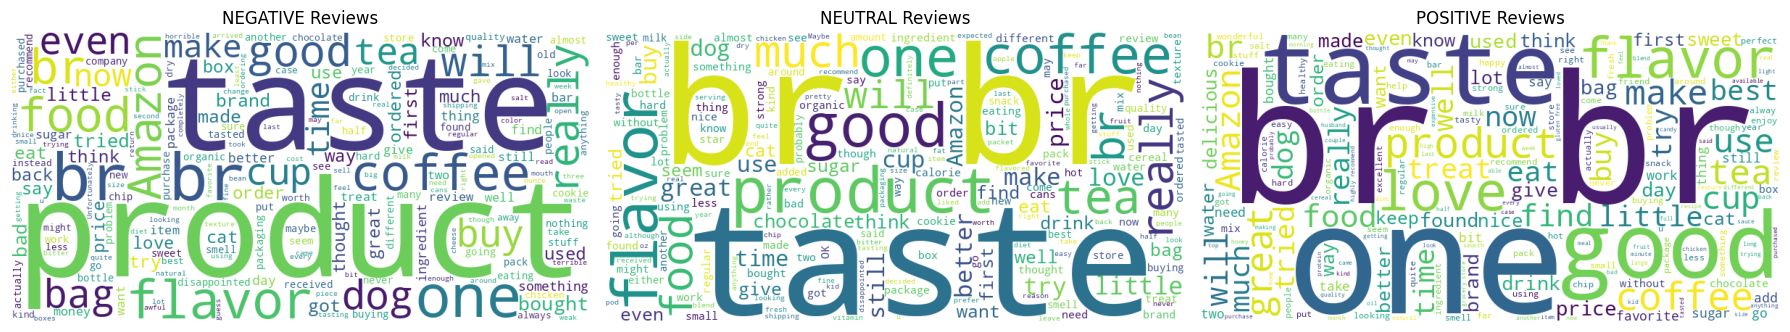

In [23]:
#Figure 3: Word Cloud
fig, axes = plt.subplots(1, 3, figsize=(18 ,5))

for i, sentiment in enumerate(['negative', 'neutral', 'positive']):
  text = ' '.join(df[df['actual_sentiment']== sentiment]['Text'])
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  axes[i].imshow(wordcloud)
  axes[i].set_title(f'{sentiment.upper()} Reviews')
  axes[i].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2770536642.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


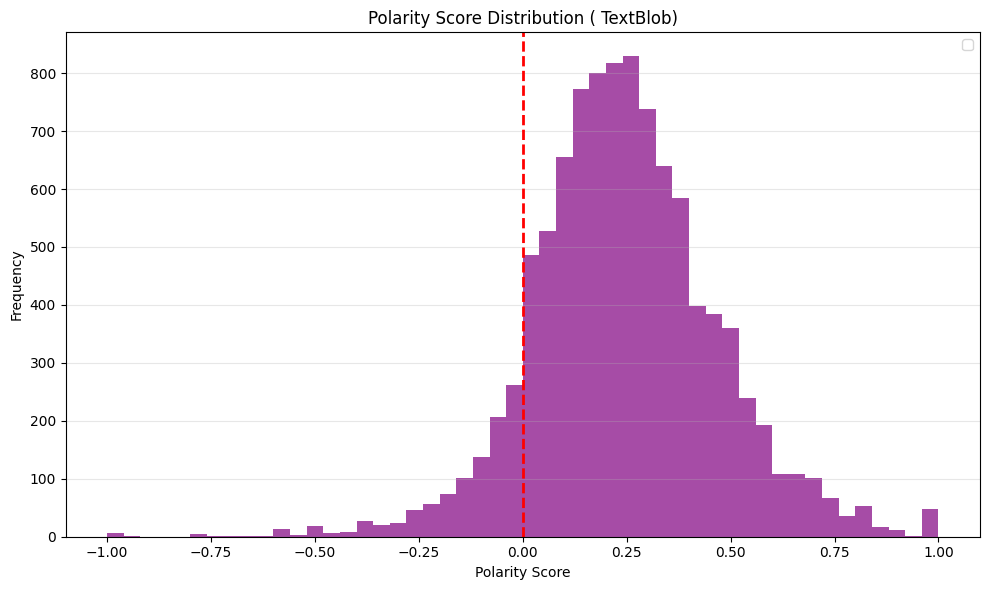

In [24]:
#Figure 4: Polarity score

plt.figure(figsize=(10, 6))
plt.hist(df['polarity'], bins=50, color='purple', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Polarity Score Distribution ( TextBlob)')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
#

STEO 10: Summary

In [29]:
print("-"*50)
print("\nSUMMARY REPORT")
print("-"*50)
print(f"Total reviews analyzed: {len(df)}")
print(f"\nActual Sentiment Breakdown:")
print(df['actual_sentiment'].value_counts())
print(f"\nTextBlob accuracy: {textblob_acc:.2%}")
print(f"VADER accuracy: {vader_acc:.2%}")
print(f"\nBest Method: {'VADER' if vader_acc > textblob_acc else 'TextBlod'}")
print("-"*50)


--------------------------------------------------

SUMMARY REPORT
--------------------------------------------------
Total reviews analyzed: 10000

Actual Sentiment Breakdown:
actual_sentiment
positive    7852
negative    1398
neutral      750
Name: count, dtype: int64

TextBlob accuracy: 79.49%
VADER accuracy: 80.99%

Best Method: VADER
--------------------------------------------------
